# Post-process

While `eodag` 's main goal is to offer an easy way to search and download EO products, it doesn't want to be a dead-end to the users who would like to post-process the products they have downloaded.

You will learn how to:
- [Products file path](#Products-file-path)
- [Sentinel: SAFE Format](#Sentinel:-SAFE-Format)
- [Data access with eodag-cube](#Data-access-with-eodag-cube)

## Products file path

The download methods all return the local path of each product downloaded. Theses paths can be fed into another program for further processing. See for instance the tutorial that makes use of [SNAP](https://step.esa.int/main/toolboxes/snap/) to detect ships on *Sentinel 1* images.

<div class="alert alert-warning">

Note

The file paths returned (strings) are in the file URI format (e.g. `file:///tmp` on Linux). You may need in some occasions to remove the `file://` prefix.

</div>

## Sentinel: SAFE Format

Sentinel products are generally distributed in the [SAFE format](https://sentiwiki.copernicus.eu/web/safe-format). AWS-based providers however offers Sentinel products in a "scattered" way, each file being able to be downloaded individually. `eodag` downloads these multiple files and automatically builds a SAFE product out of them. Image processing softwares such as [SNAP](https://step.esa.int/main/toolboxes/snap/) work well with products in the SAFE format.

## Data access with [eodag-cube](https://github.com/CS-SI/eodag-cube)

At some point `eodag` had some capabilities to directly post-process a product, i.e. to access its data. These capabilities, which relied on [xarray](https://docs.xarray.dev/en/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/), have been ported to the Python package [eodag-cube](https://github.com/CS-SI/eodag-cube) to avoid the heavy dependencies associated with `rasterio` and `GDAL` in particular. Installing this package is enough to benefit from its capabilities.

[eodag-cube](https://github.com/CS-SI/eodag-cube) extends the [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) class with a [to_xarray()](../../api_reference/eoproduct.rst#eodag_cube.api.product._product.EOProduct.to_xarray) method which returns product readable content in a `XarrayDict` (dictionary of `xarray.Dataset`).

A [ffspec](https://filesystem-spec.readthedocs.io) file refering to the data can also be obtained using the [get_file_obj()](../../api_reference/eoproduct.rst#eodag_cube.api.product._product.EOProduct.get_file_obj) method.

### Usage

In this example, a search is made to get *Sentinel 2 Level-1C* products from *Creodias S3*.

<div class="alert alert-warning">

Warning

[eodag-cube](https://github.com/CS-SI/eodag-cube) needs to be installed to run correcly the following code.

</div>

In [1]:
# Set the credentials with environment variables
import os
os.environ["EODAG__CREODIAS_S3__AUTH__CREDENTIALS__AWS_ACCESS_KEY_ID"] = "PLEASE_CHANGE_ME"
os.environ["EODAG__CREODIAS_S3__AUTH__CREDENTIALS__AWS_SECRET_ACCESS_KEY"] = "PLEASE_CHANGE_ME"

from eodag import EODataAccessGateway

dag = EODataAccessGateway()

# Define the search criteria and search for products
search_criteria = {
    "provider": "creodias_s3",
    "productType": "S2_MSI_L1C",
    "start": "2023-06-01",
    "end": "2023-06-30",
    "geom": {"lonmin": 1.306, "latmin": 43.527, "lonmax": 1.551, "latmax": 43.662},
    "cloudCover": 1  # Cloud cover < 1
}

products = dag.search(**search_criteria)
product = products[0]
product

EOProduct(id=S2A_MSIL1C_20230624T104621_N0509_R051_T31TCJ_20230624T160918, provider=creodias_s3)

The example below shows how to calculate the NDVI from the downloaded product over Toulouse.

In [2]:
toulouse_bbox=[1.435, 43.587, 1.458, 43.602]

When dealing with `rasterio` xarray engine, the `to_xarray()` method uses [Rasterio’s GDAL/AWS environment](https://rasterio.readthedocs.io/en/stable/api/rasterio.env.html#rasterio.env.Env) to open the data.

As data is lazy loaded, the environment is still needed to read its whole content.

It can be retrieved using `EOProduct.rio_env()` method.

In [3]:
with product.rio_env():
    VIR = product.assets["B04"].to_xarray().rio.clip_box(*toulouse_bbox, crs="EPSG:4326").rio.reproject(dst_crs="EPSG:4326")
    NIR = product.assets["B08"].to_xarray().rio.clip_box(*toulouse_bbox, crs="EPSG:4326").rio.reproject(dst_crs="EPSG:4326")

NDVI = (NIR - VIR) / (NIR + VIR)
NDVI

<xarray.Dataset> Size: 126kB
Dimensions:      (x: 216, y: 142, band: 1)
Coordinates:
  * x            (x) float64 2kB 1.435 1.435 1.435 1.435 ... 1.458 1.458 1.458
  * y            (y) float64 1kB 43.6 43.6 43.6 43.6 ... 43.59 43.59 43.59 43.59
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 123kB nan nan nan nan ... nan nan nan nan

The `plot` methods of `xarray.DataArray` can be used to quickly plot the NDVI.

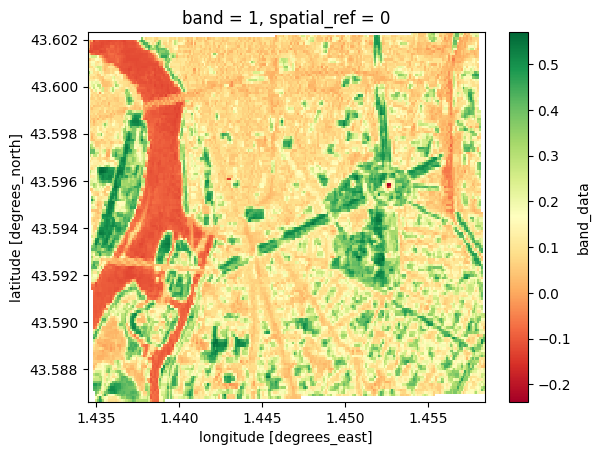

In [4]:
NDVI.band_data.plot(cmap="RdYlGn", center=False)